In [ ]:
! pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 23.4 MB/s eta 0:00:00


In [ ]:
# Import packages
import dgl
import torch
import torch.nn.functional as F
import numpy as np
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
from IPython.display import Latex
from sklearn.model_selection import train_test_split

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
dataset_enzymes = dgl.data.TUDataset(name='ENZYMES')

# Add self loop to each graph
dataset_enzymes.graph_lists = [dgl.add_self_loop(graph) for graph in dataset_enzymes.graph_lists]

Extracting file to /root/.dgl/ENZYMES


In [ ]:
dataset_enzymes[0]

(Graph(num_nodes=37, num_edges=205,
       ndata_schemes={'node_labels': Scheme(shape=(1,), dtype=torch.int64), 'node_attr': Scheme(shape=(18,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}),
 tensor([5]))

In [ ]:
print('Number of graph categories:', dataset_enzymes.num_labels)
print('Dimension of nodes features', dataset_enzymes[0][0].ndata['node_attr'].shape[1])

Number of graph categories: 6
Dimension of nodes features 18


In [ ]:
# Split dataset into train, validation and test sets
train_sampler, val_sampler, test_sampler = dgl.data.utils.split_dataset(
        dataset_enzymes, frac_list=[0.6, 0.2, 0.2], shuffle=True)

In [ ]:
# batch graphs with GraphDataLoader
train_dataloader = GraphDataLoader(
        train_sampler, batch_size=5, drop_last=False)
val_dataloader = GraphDataLoader(
    val_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(
    test_sampler, batch_size=5, drop_last=False)

In [ ]:
'''
class BasicGraphModel(torch.nn.Module):

    def __init__(self, n_layers, input_size, hidden_size, output_size):
        super(BasicGraphModel, self).__init__()

        # Define GNN components
        self.convs = torch.nn.ModuleList()
        self.convs.append(GraphConv(input_size, hidden_size))
        for i in range(n_layers-1):
            self.convs.append(GraphConv(hidden_size, hidden_size))
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, g, x):
        # Message Passing -- Learn node representations via GCN
        for conv in self.convs[:-1]:
            x = conv(g, x)
            x = F.elu(x)
        x = self.convs[-1](g, x)
        # Readout -- average all node representations to get graph embedding
        g.ndata['h'] = x
        x = dgl.mean_nodes(g, 'h')
        # Apply linear layer to classify graph representation
        x = self.linear(x)
        return x
'''
class BasicGraphModel(torch.nn.Module):

    def __init__(self, n_layers, input_size, hidden_size, output_size):
        super(BasicGraphModel, self).__init__()

        # Define GNN components
        self.convs = torch.nn.ModuleList()
        self.convs.append(GraphConv(input_size, hidden_size))
        for i in range(n_layers-1):
            self.convs.append(GraphConv(hidden_size, hidden_size))
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, g, x):
        # Message Passing -- Learn node representations via GCN
        for conv in self.convs[:-1]:
            x = conv(g, x)
            x = F.leaky_relu(x)
        x = self.convs[-1](g, x)
        # Readout -- average all node representations to get graph embedding
        g.ndata['h'] = x
        x = dgl.mean_nodes(g, 'h')
        # Apply linear layer to classify graph representation
        x = self.linear(x)
        return x


In [ ]:
def train(model, loss_fcn, optimizer, train_dataloader, val_dataloader, num_epochs):
    model = model.double()
    model.train()

    for epoch in range(num_epochs):
        losses = []
        for batch, batched_graph in enumerate(train_dataloader):
            batched_graph, labels = batched_graph
            logits = model(batched_graph, batched_graph.ndata['node_attr'].double())
            loss = loss_fcn(logits, labels.T[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.mean(losses)

        if epoch % 5 == 0:
            print("Epoch {} | Loss: {:.4f}".format(epoch, loss_data))
            test(model, loss_fcn, val_dataloader)

In [ ]:
def test(model, loss_fcn, dataloader):
    scores = []
    for batch, batched_graph in enumerate(dataloader):
        batched_graph, labels = batched_graph
        scores.append(
            evaluate(model, batched_graph, labels, loss_fcn))
    mean_scores = np.mean(scores)
    print("Accuracy score: {:.4f}".format(mean_scores))

In [ ]:
def evaluate(model, batched_graph, labels, loss_fcn):
    model = model.double()
    model.eval()
    with torch.no_grad():
        output = model(batched_graph, batched_graph.ndata['node_attr'].double())

    labels = labels.T[0]
    loss = loss_fcn(output, labels)
    predict = output.argmax(dim=1)
    score = (labels == predict).sum().item() / len(labels)

    return score

In [ ]:
# Store features
n_features, n_classes = dataset_enzymes[0][0].ndata['node_attr'].shape[1], \
    dataset_enzymes.num_labels
hidden_size = 128

# Define model, loss function and optimizer
model = BasicGraphModel(n_layers=3, input_size=n_features,
                        hidden_size=hidden_size, output_size=n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fcn = torch.nn.CrossEntropyLoss()

# Train and test
train(model, loss_fcn, optimizer,
        train_dataloader, val_dataloader, num_epochs=150)
test(model, loss_fcn, test_dataloader)


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0 | Loss: 2.1130
Accuracy score: 0.2583
Epoch 5 | Loss: 1.6849
Accuracy score: 0.2750
Epoch 10 | Loss: 1.6269
Accuracy score: 0.3583
Epoch 15 | Loss: 1.5705
Accuracy score: 0.3750
Epoch 20 | Loss: 1.5048
Accuracy score: 0.3667
Epoch 25 | Loss: 1.4568
Accuracy score: 0.4500
Epoch 30 | Loss: 1.4261
Accuracy score: 0.4417
Epoch 35 | Loss: 1.3842
Accuracy score: 0.4583
Epoch 40 | Loss: 1.3425
Accuracy score: 0.4500
Epoch 45 | Loss: 1.3042
Accuracy score: 0.4000
Epoch 50 | Loss: 1.2573
Accuracy score: 0.3750
Epoch 55 | Loss: 1.2118
Accuracy score: 0.3750
Epoch 60 | Loss: 1.1466
Accuracy score: 0.4333
Epoch 65 | Loss: 1.1074
Accuracy score: 0.4333
Epoch 70 | Loss: 1.0679
Accuracy score: 0.4333
Epoch 75 | Loss: 1.0520
Accuracy score: 0.4167
Epoch 80 | Loss: 0.9581
Accuracy score: 0.4333
Epoch 85 | Loss: 0.8889
Accuracy score: 0.4500
Epoch 90 | Loss: 0.7876
Accuracy score: 0.4500
Epoch 95 | Loss: 0.7196
Accuracy score: 0.4667
Epoch 100 | Loss: 0.6559
Accuracy score: 0.4917
Epoch 105 | Lo

In [ ]:
enzymes_nx_graphs = [g.to_networkx() for g in dataset_enzymes.graph_lists]

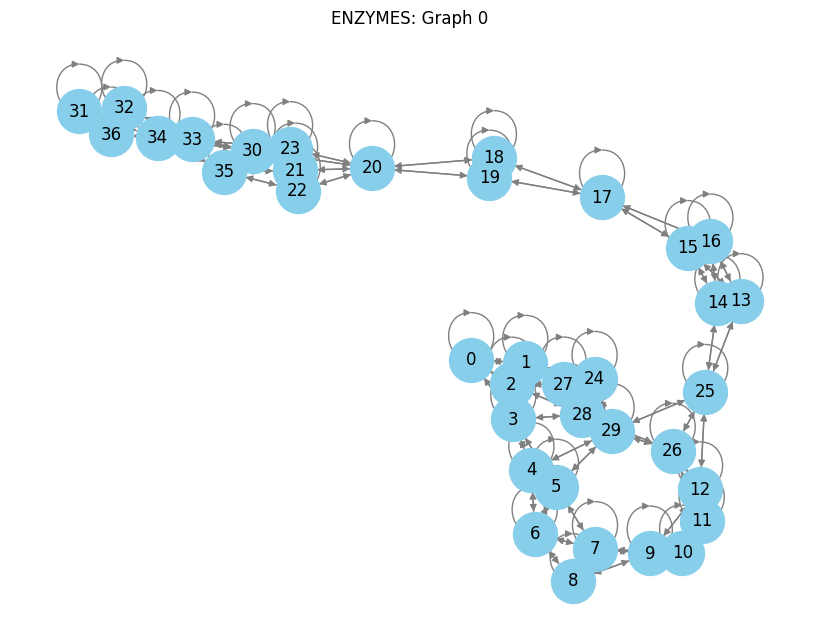

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(nx_graph, title=None):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(nx_graph, seed=42)
    nx.draw(nx_graph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1000)
    if title:
        plt.title(title)
    plt.show()

# Visualize the first graph from the ENZYMES dataset
visualize_graph(enzymes_nx_graphs[0], title='ENZYMES: Graph 0')

In [ ]:
graph, _ = dataset_enzymes[0]  # Get the first graph from the dataset
node_attributes = graph.ndata['node_attr']  # Access the node attributes

print("Node attributes shape:", node_attributes.shape)

Node attributes shape: torch.Size([37, 18])
